In [13]:
from datasets import load_dataset
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from gensim.models import Word2Vec, FastText
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding, Input, Lambda
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
import tensorflow_hub as hub
#import tensorflow_text as text
import matplotlib.pyplot as plt

# Загрузка IMDB
dataset = load_dataset("imdb")
train_df = pd.DataFrame(dataset["train"])
test_df = pd.DataFrame(dataset["test"])

# Для ускорения возьмём подвыборку
#train_df = train_df.sample(5000, random_state=42)
#test_df = test_df.sample(2000, random_state=42)

# Тексты и метки (0 = негативный, 1 = позитивный)
X_train = train_df["text"].values
y_train = train_df["label"].values
X_test = test_df["text"].values
y_test = test_df["label"].values

In [3]:
# Векторизация текстов
tfidf = TfidfVectorizer(max_features=10000, stop_words="english")
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

# Обучение модели
lr = LogisticRegression(max_iter=500)
lr.fit(X_train_tfidf, y_train)

# Оценка
y_pred_tfidf = lr.predict(X_test_tfidf)
print("TF-IDF + Logistic Regression:")
print(classification_report(y_test, y_pred_tfidf, target_names=["Negative", "Positive"]))
print(f"Accuracy: {accuracy_score(y_test, y_pred_tfidf):.4f}")

TF-IDF + Logistic Regression:
              precision    recall  f1-score   support

    Negative       0.88      0.88      0.88     12500
    Positive       0.88      0.88      0.88     12500

    accuracy                           0.88     25000
   macro avg       0.88      0.88      0.88     25000
weighted avg       0.88      0.88      0.88     25000

Accuracy: 0.8792


In [4]:
# Токенизация текстов
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Паддинг до одинаковой длины
max_len = 200  # Увеличим длину для IMDB
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len)

# Обучение Word2Vec
sentences = [text.split() for text in X_train]
w2v_model = Word2Vec(sentences, vector_size=100, window=5, min_count=3, workers=4)

# Матрица эмбеддингов
embedding_matrix = np.zeros((len(tokenizer.word_index) + 1, 100))
for word, i in tokenizer.word_index.items():
    if word in w2v_model.wv:
        embedding_matrix[i] = w2v_model.wv[word]

# Модель LSTM
model = Sequential([
    Embedding(input_dim=len(tokenizer.word_index) + 1,
              output_dim=100,
              weights=[embedding_matrix],
              input_length=max_len,
              trainable=False),
    LSTM(128),
    Dense(1, activation="sigmoid")  # Бинарная классификация
])
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

# Обучение
history = model.fit(X_train_pad, y_train, epochs=5, batch_size=64, validation_split=0.1)

# Оценка
y_pred_w2v = (model.predict(X_test_pad) > 0.5).astype("int32")
print("\nWord2Vec + LSTM:")
print(classification_report(y_test, y_pred_w2v, target_names=["Negative", "Positive"]))
print(f"Accuracy: {accuracy_score(y_test, y_pred_w2v):.4f}")

Epoch 1/5


C:\Users\R1sed\PycharmProjects\pythonProject\.venv\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


352/352 ━━━━━━━━━━━━━━━━━━━━ 34s 93ms/step - accuracy: 0.6545 - loss: 0.6222 - val_accuracy: 0.5444 - val_loss: 0.7178
Epoch 2/5
352/352 ━━━━━━━━━━━━━━━━━━━━ 35s 101ms/step - accuracy: 0.7942 - loss: 0.4440 - val_accuracy: 0.8428 - val_loss: 0.3943
Epoch 3/5
352/352 ━━━━━━━━━━━━━━━━━━━━ 36s 102ms/step - accuracy: 0.8592 - loss: 0.3263 - val_accuracy: 0.7920 - val_loss: 0.4563
Epoch 4/5
352/352 ━━━━━━━━━━━━━━━━━━━━ 32s 90ms/step - accuracy: 0.8756 - loss: 0.2927 - val_accuracy: 0.8880 - val_loss: 0.2950
Epoch 5/5
352/352 ━━━━━━━━━━━━━━━━━━━━ 45s 127ms/step - accuracy: 0.8976 - loss: 0.2448 - val_accuracy: 0.8044 - val_loss: 0.4673
782/782 ━━━━━━━━━━━━━━━━━━━━ 16s 20ms/step

Word2Vec + LSTM:
              precision    recall  f1-score   support

    Negative       0.83      0.93      0.87     12500
    Positive       0.92      0.80      0.86     12500

    accuracy                           0.86     25000
   macro avg       0.87      0.86      0.86     25000
weighted avg       0.87      

In [5]:
# Обучение FastText
ft_model = FastText(sentences, vector_size=100, window=5, min_count=3, workers=4)

# Матрица эмбеддингов
embedding_matrix_ft = np.zeros((len(tokenizer.word_index) + 1, 100))
for word, i in tokenizer.word_index.items():
    if word in ft_model.wv:
        embedding_matrix_ft[i] = ft_model.wv[word]

# Модель LSTM с FastText
model_ft = Sequential([
    Embedding(input_dim=len(tokenizer.word_index) + 1,
              output_dim=100,
              weights=[embedding_matrix_ft],
              input_length=max_len,
              trainable=False),
    LSTM(128),
    Dense(1, activation="sigmoid")
])
model_ft.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

# Обучение
history_ft = model_ft.fit(X_train_pad, y_train, epochs=5, batch_size=64, validation_split=0.1)

# Оценка
y_pred_ft = (model_ft.predict(X_test_pad) > 0.5).astype("int32")
print("\nFastText + LSTM:")
print(classification_report(y_test, y_pred_ft, target_names=["Negative", "Positive"]))
print(f"Accuracy: {accuracy_score(y_test, y_pred_ft):.4f}")

Epoch 1/5


C:\Users\R1sed\PycharmProjects\pythonProject\.venv\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


352/352 ━━━━━━━━━━━━━━━━━━━━ 38s 104ms/step - accuracy: 0.6453 - loss: 0.6144 - val_accuracy: 0.7336 - val_loss: 0.5342
Epoch 2/5
352/352 ━━━━━━━━━━━━━━━━━━━━ 31s 89ms/step - accuracy: 0.8004 - loss: 0.4353 - val_accuracy: 0.8220 - val_loss: 0.4358
Epoch 3/5
352/352 ━━━━━━━━━━━━━━━━━━━━ 31s 89ms/step - accuracy: 0.8486 - loss: 0.3483 - val_accuracy: 0.8368 - val_loss: 0.4023
Epoch 4/5
352/352 ━━━━━━━━━━━━━━━━━━━━ 31s 88ms/step - accuracy: 0.8700 - loss: 0.3084 - val_accuracy: 0.8536 - val_loss: 0.3520
Epoch 5/5
352/352 ━━━━━━━━━━━━━━━━━━━━ 32s 90ms/step - accuracy: 0.8889 - loss: 0.2697 - val_accuracy: 0.9252 - val_loss: 0.2114
782/782 ━━━━━━━━━━━━━━━━━━━━ 16s 21ms/step

FastText + LSTM:
              precision    recall  f1-score   support

    Negative       0.91      0.74      0.81     12500
    Positive       0.78      0.93      0.85     12500

    accuracy                           0.83     25000
   macro avg       0.84      0.83      0.83     25000
weighted avg       0.84      0.

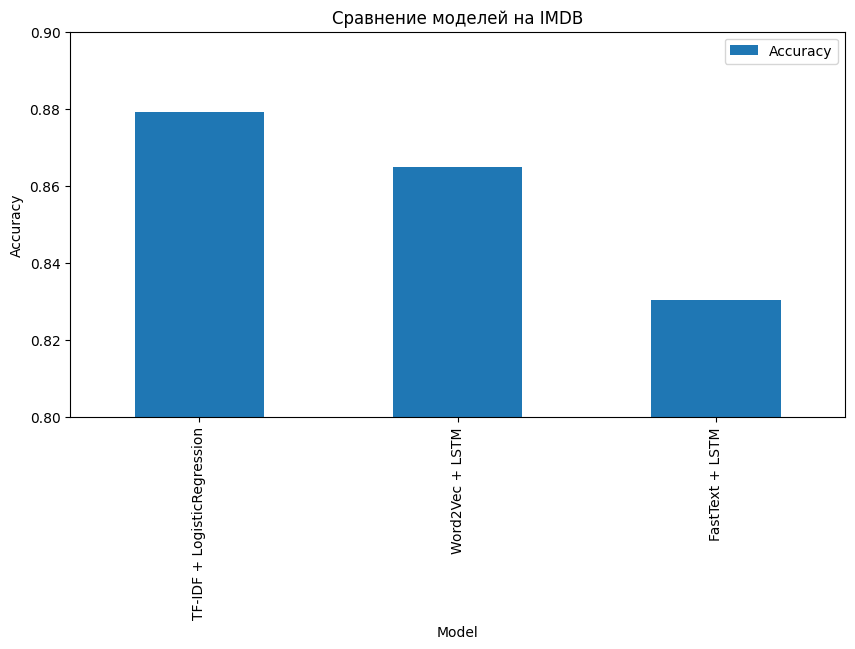

In [6]:
results = {
    "Model": ["TF-IDF + LogisticRegression", "Word2Vec + LSTM", "FastText + LSTM"],
    "Accuracy": [
        accuracy_score(y_test, y_pred_tfidf),
        accuracy_score(y_test, y_pred_w2v),
        accuracy_score(y_test, y_pred_ft)
    ]
}

pd.DataFrame(results).set_index("Model").plot(kind="bar", figsize=(10, 5))
plt.title("Сравнение моделей на IMDB")
plt.ylabel("Accuracy")
plt.ylim(0.8, 0.9)
plt.show()

In [8]:
# Загрузка предобученных GloVe векторов (100d)
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip

embeddings_index = {}
with open("glove.6B.100d.txt", "r", encoding="utf-8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype="float32")
        embeddings_index[word] = coefs

# Матрица эмбеддингов для GloVe
embedding_matrix_glove = np.zeros((len(tokenizer.word_index) + 1, 100))
for word, i in tokenizer.word_index.items():
    if word in embeddings_index:
        embedding_matrix_glove[i] = embeddings_index[word]

# Модель LSTM с GloVe
model_glove = Sequential([
    Embedding(input_dim=len(tokenizer.word_index) + 1,
              output_dim=100,
              weights=[embedding_matrix_glove],
              input_length=max_len,
              trainable=False),
    LSTM(128),
    Dense(1, activation="sigmoid")
])
model_glove.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
model_glove.fit(X_train_pad, y_train, epochs=5, batch_size=64, validation_split=0.1)

y_pred_glove = (model_glove.predict(X_test_pad) > 0.5).astype("int32")
print("\nGloVe + LSTM:")
print(classification_report(y_test, y_pred_glove, target_names=["Negative", "Positive"]))
print(f"Accuracy: {accuracy_score(y_test, y_pred_glove):.4f}")

"wget" ­Ґ пў«пҐвбп ў­гваҐ­­Ґ© Ё«Ё ў­Ґи­Ґ©
Є®¬ ­¤®©, ЁбЇ®«­пҐ¬®© Їа®Ја ¬¬®© Ё«Ё Ї ЄҐв­л¬ д ©«®¬.
"unzip" ­Ґ пў«пҐвбп ў­гваҐ­­Ґ© Ё«Ё ў­Ґи­Ґ©
Є®¬ ­¤®©, ЁбЇ®«­пҐ¬®© Їа®Ја ¬¬®© Ё«Ё Ї ЄҐв­л¬ д ©«®¬.


FileNotFoundError: [Errno 2] No such file or directory: 'glove.6B.100d.txt'

In [14]:
# Загрузка ELMo из TensorFlow Hub
elmo = hub.KerasLayer("https://tfhub.dev/google/elmo/3", trainable=False, signature="default", output_key="default")

# Модель с ELMo
input_text = Input(shape=(), dtype=tf.string)
elmo_embedding = elmo(input_text)
dense = Dense(1, activation="sigmoid")(elmo_embedding)
model_elmo = tf.keras.Model(inputs=[input_text], outputs=[dense])
model_elmo.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

# Обучение
model_elmo.fit(X_train, y_train, epochs=5, batch_size=32, validation_split=0.1)

y_pred_elmo = (model_elmo.predict(X_test) > 0.5).astype("int32")
print("\nELMo + Dense:")
print(classification_report(y_test, y_pred_elmo, target_names=["Negative", "Positive"]))
print(f"Accuracy: {accuracy_score(y_test, y_pred_elmo):.4f}")

TypeError: Exception encountered when calling layer 'keras_layer' (type KerasLayer).

Binding inputs to tf.function failed due to `A KerasTensor cannot be used as input to a TensorFlow function. A KerasTensor is a symbolic placeholder for a shape and dtype, used when constructing Keras Functional models or Keras Functions. You can only use it as input to a Keras layer or a Keras operation (from the namespaces `keras.layers` and `keras.ops`). You are likely doing something like:

```
x = Input(...)
...
tf_fn(x)  # Invalid.
```

What you should do instead is wrap `tf_fn` in a layer:

```
class MyLayer(Layer):
    def call(self, x):
        return tf_fn(x)

x = MyLayer()(x)
```
`. Received args: (<KerasTensor shape=(None,), dtype=string, sparse=False, ragged=False, name=keras_tensor_8>,) and kwargs: {} for signature: (text: TensorSpec(shape=(None,), dtype=tf.string, name='text')) -> Dict[['lstm_outputs1', TensorSpec(shape=(None, None, 1024), dtype=tf.float32, name=None)], ['lstm_outputs2', TensorSpec(shape=(None, None, 1024), dtype=tf.float32, name=None)], ['word_emb', TensorSpec(shape=(None, None, 512), dtype=tf.float32, name=None)], ['elmo', TensorSpec(shape=(None, None, 1024), dtype=tf.float32, name=None)], ['sequence_len', TensorSpec(shape=(None,), dtype=tf.int32, name=None)], ['default', TensorSpec(shape=(None, 1024), dtype=tf.float32, name=None)]].
Fallback to flat signature also failed due to: pruned(text): expected argument #0(zero-based) to be a Tensor; got KerasTensor (<KerasTensor shape=(None,), dtype=string, sparse=False, ragged=False, name=keras_tensor_8>).

Call arguments received by layer 'keras_layer' (type KerasLayer):
  • inputs=<KerasTensor shape=(None,), dtype=string, sparse=False, ragged=False, name=keras_tensor_8>
  • training=None